<hr style="height:2px;">

# Demo: Neural network training for isotropic reconstruction of Zebrafish retina

This notebook demonstrates training a CARE model for an isotropic reconstruction task, assuming that training data was already generated via [1_datagen.ipynb](1_datagen.ipynb) and has been saved to disk to the file ``data/my_training_data.npz``. Note that the training approach is exactly the same as in the standard CARE approach, what differs is the [training data generation](1_datagen.ipynb) and [prediction](3_prediction.ipynb).

Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, IsotropicCARE

The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [2]:
# limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Load training data generated via [1_datagen.ipynb](1_datagen.ipynb), use 10% as validation data.

In [3]:
psf = 1
(X,Y), (X_val,Y_val), axes = load_training_data(f'data/my_training_data_psf_{psf}.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 30413
number of validation images:	 3379
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


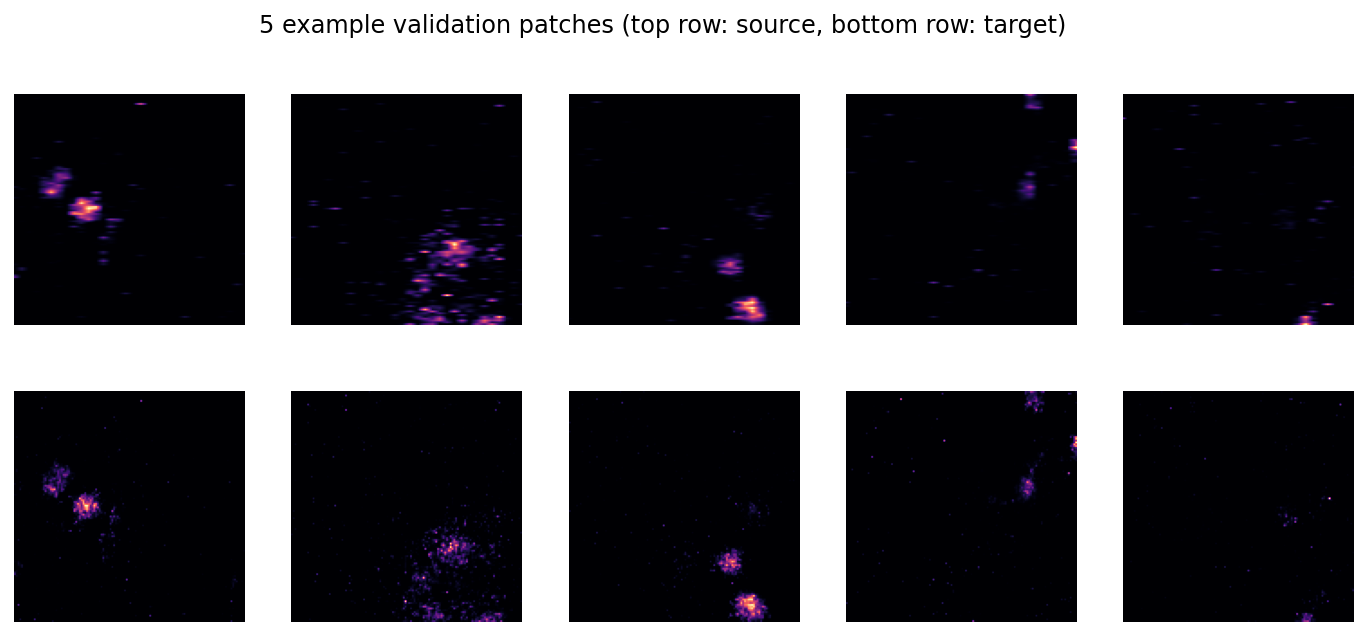

In [4]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [5]:
config = Config(axes, n_channel_in, n_channel_out,
                train_steps_per_epoch=500, train_epochs=200,
                train_batch_size=8)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=200, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=500, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 200,
 'train_steps_per_epoch': 500,
 'train_learning_rate': 0.0004,
 'train_batch_size': 8,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create an isotropic CARE model with the chosen configuration:

In [6]:
model_path = f'my_model_psf_{psf}_ batch_{config.train_batch_size}'

model = IsotropicCARE(config, model_path, basedir='models')

/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/csbdeep/models/base_model.py:148: UserWarning: output path for model already exists, files may be overwritten: /home/jordao/Softwares/CSBDeep/examples/isotropic_reconstruction/models/my_model_psf_1_ batch_8
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) (example below), which allows you to inspect the losses during training.
Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.`
Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

![](http://csbdeep.bioimagecomputing.com/img/tensorboard_isotropic_reconstruction.png)

In [7]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/200
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f0d9206d0d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f0d9206d0d0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/jordao/miniconda3/envs/csbdeep/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f0d9206d280>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f0d9206d280>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f0d9206d3a0>: found multiple definitions wi

Epoch 36/200
500/500 [==============================] - 183s 367ms/step - loss: 0.2182 - mse: 192.8885 - mae: 0.2182 - val_loss: 0.2153 - val_mse: 141.8393 - val_mae: 0.2153
Epoch 37/200
500/500 [==============================] - 9s 17ms/step - loss: 0.2198 - mse: 135.0656 - mae: 0.2198 - val_loss: 0.2130 - val_mse: 120.1410 - val_mae: 0.2130
Epoch 38/200
500/500 [==============================] - 9s 18ms/step - loss: 0.2190 - mse: 136.7537 - mae: 0.2190 - val_loss: 0.2174 - val_mse: 171.8533 - val_mae: 0.2174
Epoch 39/200
500/500 [==============================] - 9s 18ms/step - loss: 0.2109 - mse: 147.1324 - mae: 0.2109 - val_loss: 0.2116 - val_mse: 121.6779 - val_mae: 0.2116
Epoch 40/200
500/500 [==============================] - 9s 18ms/step - loss: 0.2145 - mse: 114.0871 - mae: 0.2145 - val_loss: 0.2176 - val_mse: 140.5129 - val_mae: 0.2176
Epoch 41/200
500/500 [==============================] - 10s 21ms/step - loss: 0.2208 - mse: 146.2172 - mae: 0.2208 - val_loss: 0.2158 - val_ms

500/500 [==============================] - 9s 18ms/step - loss: 0.1921 - mse: 70.1959 - mae: 0.1921 - val_loss: 0.2003 - val_mse: 98.1195 - val_mae: 0.2003
Epoch 84/200
500/500 [==============================] - 9s 17ms/step - loss: 0.1976 - mse: 90.2754 - mae: 0.1976 - val_loss: 0.2057 - val_mse: 123.8862 - val_mae: 0.2057
Epoch 85/200
500/500 [==============================] - 9s 18ms/step - loss: 0.1926 - mse: 65.4663 - mae: 0.1926 - val_loss: 0.2017 - val_mse: 95.2879 - val_mae: 0.2017
Epoch 86/200
500/500 [==============================] - 9s 17ms/step - loss: 0.1914 - mse: 58.3693 - mae: 0.1914 - val_loss: 0.2006 - val_mse: 95.4938 - val_mae: 0.2006
Epoch 87/200
500/500 [==============================] - 9s 17ms/step - loss: 0.1918 - mse: 63.0602 - mae: 0.1918 - val_loss: 0.2005 - val_mse: 89.2843 - val_mae: 0.2005
Epoch 88/200
500/500 [==============================] - 9s 17ms/step - loss: 0.1992 - mse: 96.7678 - mae: 0.1992 - val_loss: 0.1990 - val_mse: 89.2512 - val_mae: 0.199

KeyboardInterrupt: 

Plot final training history (available in TensorBoard during training):

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

In [ ]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [ ]:
model.export_TF()